<a href="https://colab.research.google.com/github/sukyoung11/mobis/blob/main/Copy_of_DL_05_B_AE_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AE (AutoEncoder) & Anomaly Detection

## 1. Load dataset

In [ ]:
!gdown --folder https://drive.google.com/drive/folders/12_pMH77NyqSnp8NY0EFzZn1dODgrx_p8?usp=drive_link
!unzip dataset/data_3000.zip -d ./data3000

Retrieving folder contents
Processing file 1T6zw4ggFfFlPQChqWia-VLKct1DTSLK6 data_500.zip
Processing file 1kHHoZPyk0_lCJYwqqaxd0hmBAdAxqEQY data_1000.zip
Processing file 12M-FQcVzzumCnhmFrzPkzeBoBZQtBSbj data_2000.zip
Processing file 1pNYu7bAEp8Lw08-VXMmHAgmEnJNhuhAF data_3000.zip
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1T6zw4ggFfFlPQChqWia-VLKct1DTSLK6
To: /content/dataset/data_500.zip
100% 567k/567k [00:00<00:00, 10.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kHHoZPyk0_lCJYwqqaxd0hmBAdAxqEQY
To: /content/dataset/data_1000.zip
100% 1.20M/1.20M [00:00<00:00, 10.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=12M-FQcVzzumCnhmFrzPkzeBoBZQtBSbj
To: /content/dataset/data_2000.zip
100% 2.27M/2.27M [00:00<00:00, 18.4MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1pNYu7bAEp8Lw08-VXMmHAgmEnJNhuhAF
From (redirected): https://drive.

## 2. Import python libraries and define util functions

In [ ]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# function to set seed
def set_seed(seed=42):
    # fix random seed
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # CuDNN setup
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# function to read and display images
def img_read_plot(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)  # convert the image to grayscale
    plt.imshow(img, cmap='gray')
    plt.xticks([])  # x axis
    plt.yticks([])  # y axis
    plt.show()  # display the image
    return img

# function to read images
def img_read(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)  # convert the image to grayscale
    return img

# function to plot a line graph for loss history after model training
def plot_loss(loss_train_history, title=None):

    plt.plot(loss_train_history)
    if title is not None:
        plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Train data'], loc=0)
    # plt.show()

In [ ]:
set_seed(0)

## 3. Check dataset

In [ ]:
path = './data3000/22.5651.jpg'
from PIL import Image
img = Image.open(path)
img.show()
img_array = np.array(img)
print(img_array.shape)

(56, 56)


## 4. Convert images into trainable data

In [ ]:
# image size = 56 x 56, 3000 images

# specify the below path to the unzipped data (ensure it ends with '/')
# you can change the file path if needed
src = './data3000/'

files = os.listdir(src)  # get the list of files in the source directory

X,Y = [],[]  # initialize empty lists for storing images and labels

# loop through the files, read each image, and normalize it (0 to 1)
for file in files:
    X.append(img_read(src,file)/255.)  # normalize the image
    Y.append(1)  # normal label: 1

# convert the data to array
X = np.array(X)
Y = np.array(Y)

# check the shape of the data
print('X.shape:',np.shape(X),'Y.shape:',np.shape(Y))

X.shape: (3000, 56, 56) Y.shape: (3000,)


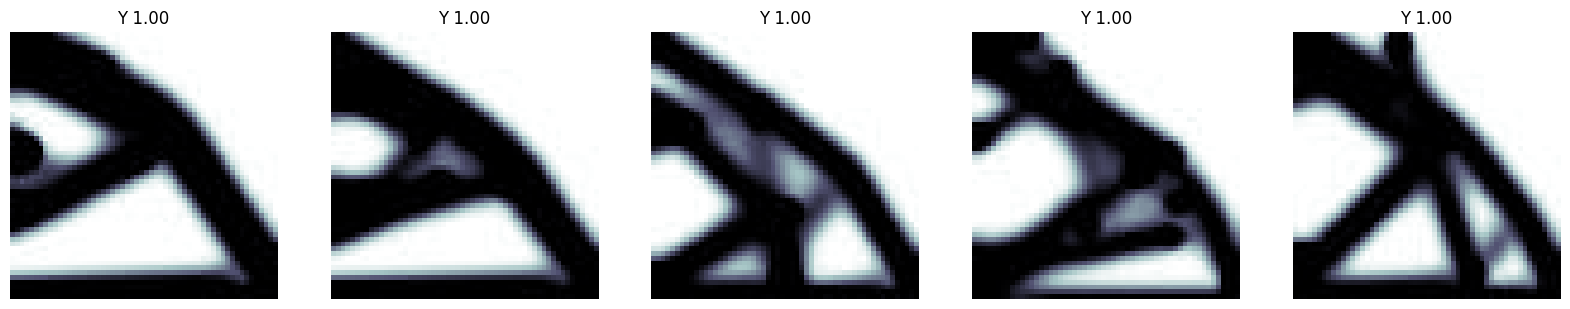

In [ ]:
# display images
fig = plt.figure(figsize=(20,10))
nplot = 5

for i in range(1,nplot+1):
    ax = fig.add_subplot(1,nplot,i)
    ax.imshow(X[i, :, :],cmap = plt.cm.bone)
    ax.set_title(f"Y {Y[i]:.2f}")
    ax.axis('off')
plt.show()

## 5. Define dataloader

In [ ]:
# split the data into 80% training set and 20% test set (test set can be considered as validation)
train_images, test_images, train_labels, test_labels = train_test_split(X,Y, test_size=0.2, random_state=1,shuffle=True)

# print the shapes and types of the training and test datasets
print(np.shape(train_images), np.shape(test_images))
print(type(train_images), type(test_images))

print(np.shape(train_labels),np.shape(test_labels))
print(type(train_labels), type(test_labels))

# reshape the (image,image) images into (image*image,) size vectors
train_images = train_images.reshape((len(train_images), np.prod(train_images.shape[1:]))).astype('float32')
test_images = test_images.reshape((len(test_images), np.prod(test_images.shape[1:]))).astype('float32')

print("Datasets_train_shape:{}  Datasets_test_shape:{}".format(np.shape(train_images),np.shape(test_images)))

# convert data to PyTorch tensors
train_images = torch.tensor(train_images, dtype=torch.float32).to(device)
train_labels = torch.tensor(train_labels, dtype=torch.float32) # don't need to use labels
test_images = torch.tensor(test_images, dtype=torch.float32).to(device)
test_labels = torch.tensor(test_labels, dtype=torch.float32)   # don't need to use labels

(2400, 56, 56) (600, 56, 56)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(2400,) (600,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
Datasets_train_shape:(2400, 3136)  Datasets_test_shape:(600, 3136)


## 6. Set to model architecture

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(image_size, mid_dim),
            nn.ReLU(),
            nn.Linear(mid_dim, h_dim),
            nn.ReLU())

        self.decoder = nn. Sequential(
            nn.Linear(h_dim, mid_dim),
            nn.ReLU(),
            nn.Linear(mid_dim, image_size),
            nn.ReLU())

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded

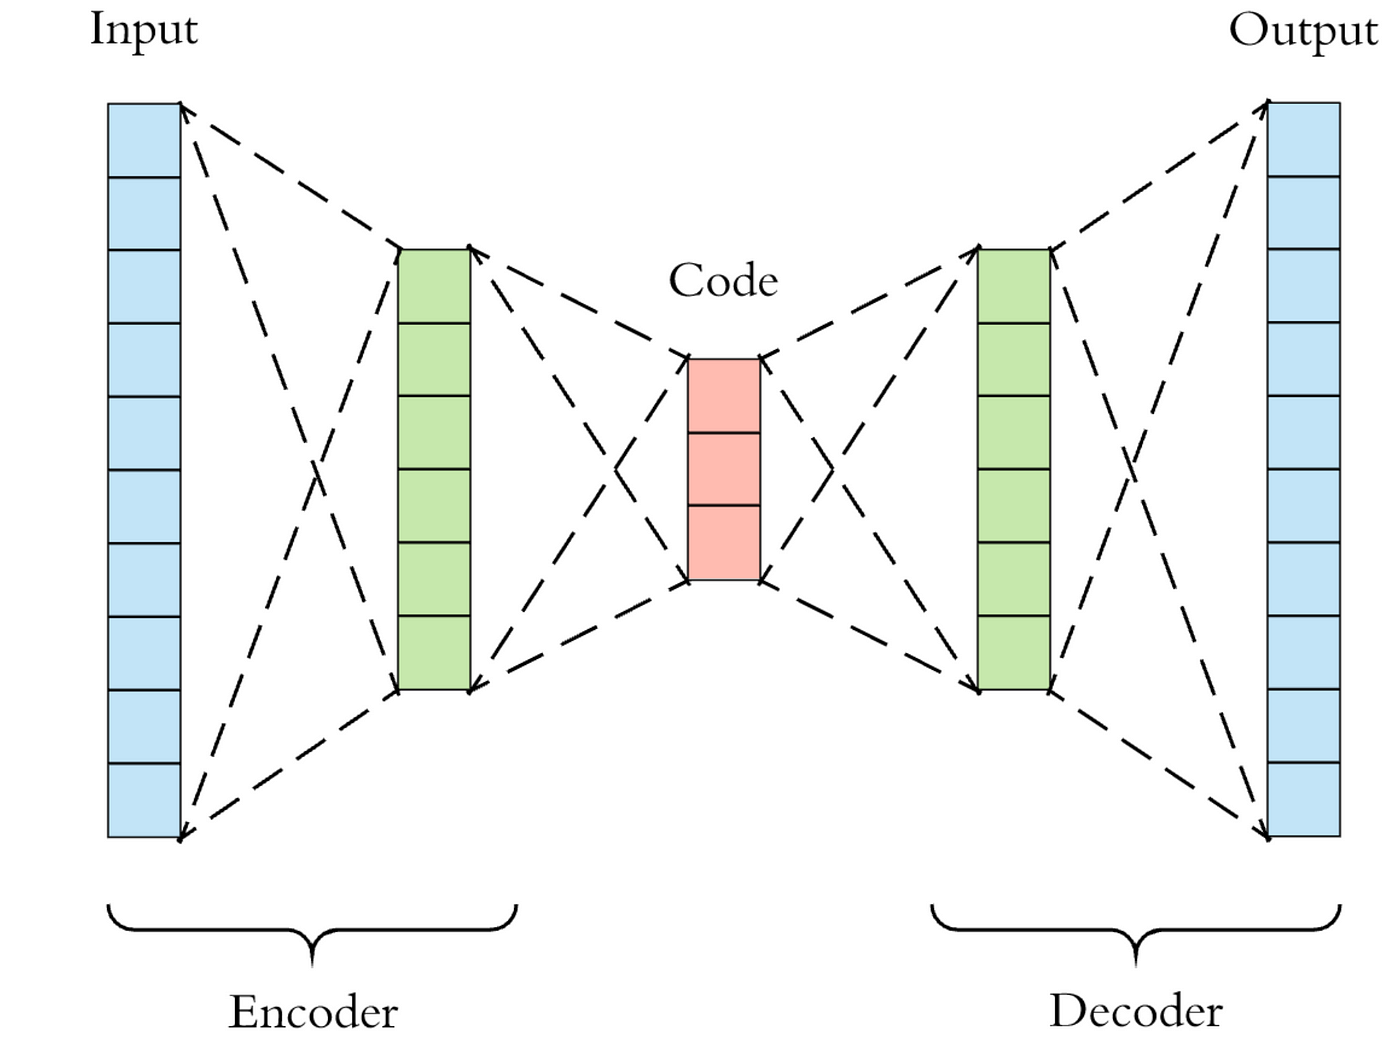

## 7. Set model hyperparameters

In [ ]:
# model architecture parameters
image_size = np.shape(train_images[0])[0]  # (fixed) input size
mid_dim = 512  # hidden layer(middle) dimension
h_dim = 20  # hidden layer(latent) dimension

# training parameters
num_epochs = 200
batch_size = 20
learning_rate = 1e-3

In [ ]:
autoencoder = Autoencoder().to(device)

# print the model's summary
summary(autoencoder, (image_size,))  # input shape: (channels, height, width)

autoencoder

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]       1,606,144
              ReLU-2                  [-1, 512]               0
            Linear-3                   [-1, 20]          10,260
              ReLU-4                   [-1, 20]               0
            Linear-5                  [-1, 512]          10,752
              ReLU-6                  [-1, 512]               0
            Linear-7                 [-1, 3136]       1,608,768
              ReLU-8                 [-1, 3136]               0
Total params: 3,235,924
Trainable params: 3,235,924
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 12.34
Estimated Total Size (MB): 12.42
----------------------------------------------------------------


Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=20, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=3136, bias=True)
    (3): ReLU()
  )
)

## 8. Train model

Epoch [1/200], Train_loss: 0.1343234603603681


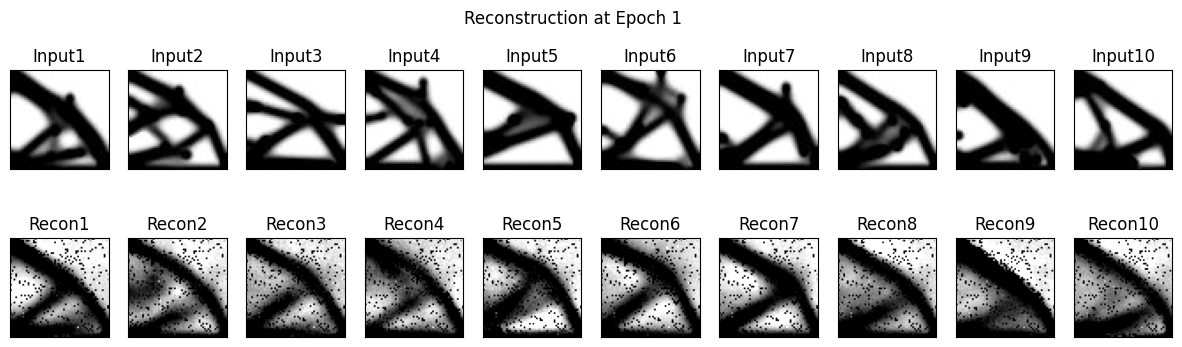

Epoch [2/200], Train_loss: 0.07560767214745283
Epoch [3/200], Train_loss: 0.06810995529716214
Epoch [4/200], Train_loss: 0.06085554671784242
Epoch [5/200], Train_loss: 0.05607408713549376
Epoch [6/200], Train_loss: 0.05266841932510336
Epoch [7/200], Train_loss: 0.04927951134741306
Epoch [8/200], Train_loss: 0.0475661950185895
Epoch [9/200], Train_loss: 0.04595044050365686
Epoch [10/200], Train_loss: 0.04411333805571
Epoch [11/200], Train_loss: 0.0420368293300271
Epoch [12/200], Train_loss: 0.04071791653210918
Epoch [13/200], Train_loss: 0.03979875768224398
Epoch [14/200], Train_loss: 0.039220402296632526
Epoch [15/200], Train_loss: 0.038707087840884925
Epoch [16/200], Train_loss: 0.03816725220531225
Epoch [17/200], Train_loss: 0.03726312201470137
Epoch [18/200], Train_loss: 0.03665810281721254
Epoch [19/200], Train_loss: 0.03584999305506547
Epoch [20/200], Train_loss: 0.03535496569238603
Epoch [21/200], Train_loss: 0.03484160060373445
Epoch [22/200], Train_loss: 0.034325590326140326
Ep

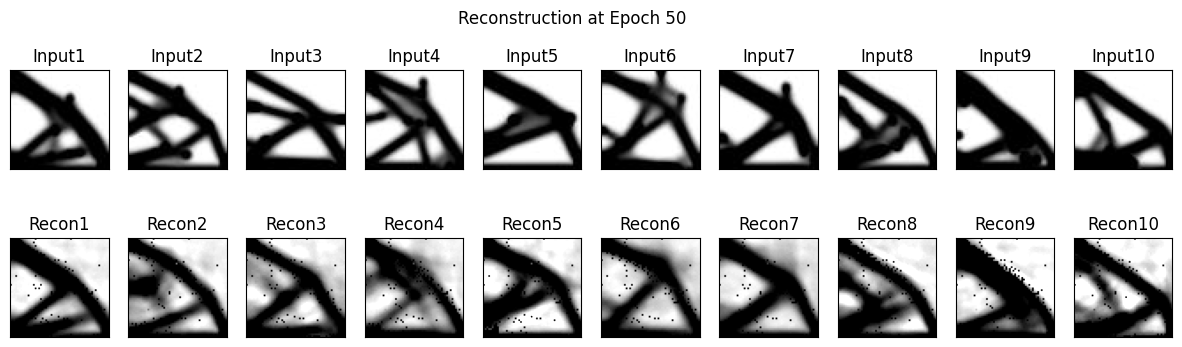

Epoch [51/200], Train_loss: 0.0287167855227987
Epoch [52/200], Train_loss: 0.028477576126654944
Epoch [53/200], Train_loss: 0.028267046871284642
Epoch [54/200], Train_loss: 0.028088500428323945
Epoch [55/200], Train_loss: 0.02798889148980379
Epoch [56/200], Train_loss: 0.0278009830818822
Epoch [57/200], Train_loss: 0.027769386752819022
Epoch [58/200], Train_loss: 0.027833894252156217
Epoch [59/200], Train_loss: 0.027618765986214083
Epoch [60/200], Train_loss: 0.0275040405181547
Epoch [61/200], Train_loss: 0.02746761031448841
Epoch [62/200], Train_loss: 0.027094323933124543
Epoch [63/200], Train_loss: 0.026986808221166333
Epoch [64/200], Train_loss: 0.0267983074610432
Epoch [65/200], Train_loss: 0.02683562772969405
Epoch [66/200], Train_loss: 0.026534102841590843
Epoch [67/200], Train_loss: 0.026261989198004206
Epoch [68/200], Train_loss: 0.0261802867675821
Epoch [69/200], Train_loss: 0.026258999792238075
Epoch [70/200], Train_loss: 0.026130762370303273
Epoch [71/200], Train_loss: 0.026

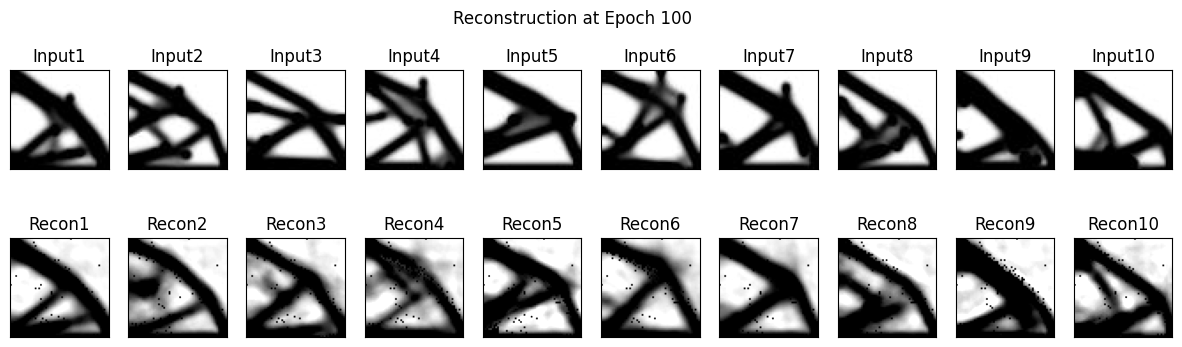

Epoch [101/200], Train_loss: 0.02401838682902356
Epoch [102/200], Train_loss: 0.02404635214867691
Epoch [103/200], Train_loss: 0.023988053559636076
Epoch [104/200], Train_loss: 0.02411872590892017
Epoch [105/200], Train_loss: 0.024105045075217883
Epoch [106/200], Train_loss: 0.023778844578191637
Epoch [107/200], Train_loss: 0.02382247063020865
Epoch [108/200], Train_loss: 0.023805306805297733
Epoch [109/200], Train_loss: 0.02370266622553269
Epoch [110/200], Train_loss: 0.023620514385402202
Epoch [111/200], Train_loss: 0.02381663614263137
Epoch [112/200], Train_loss: 0.023738024042298397
Epoch [113/200], Train_loss: 0.023484963023414216
Epoch [114/200], Train_loss: 0.023702351733421285
Epoch [115/200], Train_loss: 0.023512453539296985
Epoch [116/200], Train_loss: 0.02336294436827302
Epoch [117/200], Train_loss: 0.02342270693431298
Epoch [118/200], Train_loss: 0.02337878073255221
Epoch [119/200], Train_loss: 0.023344076005741954
Epoch [120/200], Train_loss: 0.023381914586449663
Epoch [12

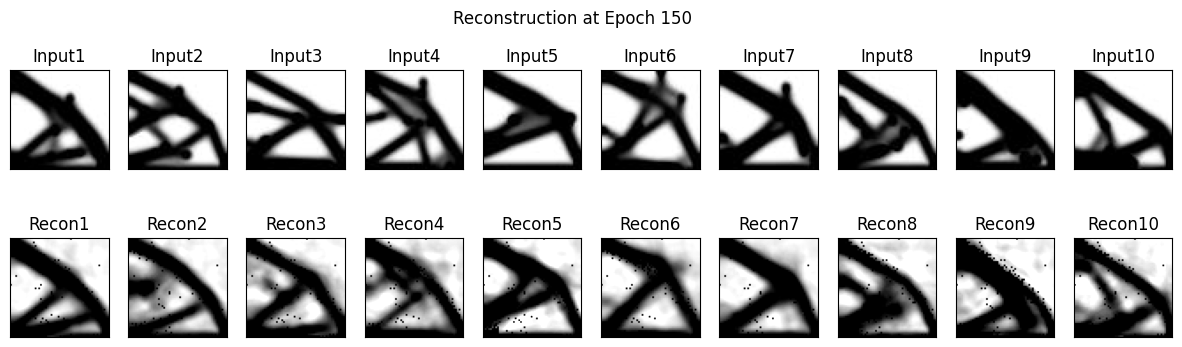

Epoch [151/200], Train_loss: 0.022831201429168384
Epoch [152/200], Train_loss: 0.022669896700729927
Epoch [153/200], Train_loss: 0.022602167151247462
Epoch [154/200], Train_loss: 0.022658164240419866
Epoch [155/200], Train_loss: 0.02242191256955266
Epoch [156/200], Train_loss: 0.02251448145446678
Epoch [157/200], Train_loss: 0.022429366347690424
Epoch [158/200], Train_loss: 0.02287222382922967
Epoch [159/200], Train_loss: 0.022541320991391937
Epoch [160/200], Train_loss: 0.02248391027872761
Epoch [161/200], Train_loss: 0.02244401367691656
Epoch [162/200], Train_loss: 0.022357821992288033
Epoch [163/200], Train_loss: 0.02237217005652686
Epoch [164/200], Train_loss: 0.02238994251626233
Epoch [165/200], Train_loss: 0.022532145523776612
Epoch [166/200], Train_loss: 0.022322289599105715
Epoch [167/200], Train_loss: 0.022233009012416004
Epoch [168/200], Train_loss: 0.022054948487008612
Epoch [169/200], Train_loss: 0.022203876279915373
Epoch [170/200], Train_loss: 0.022036475688219072
Epoch [

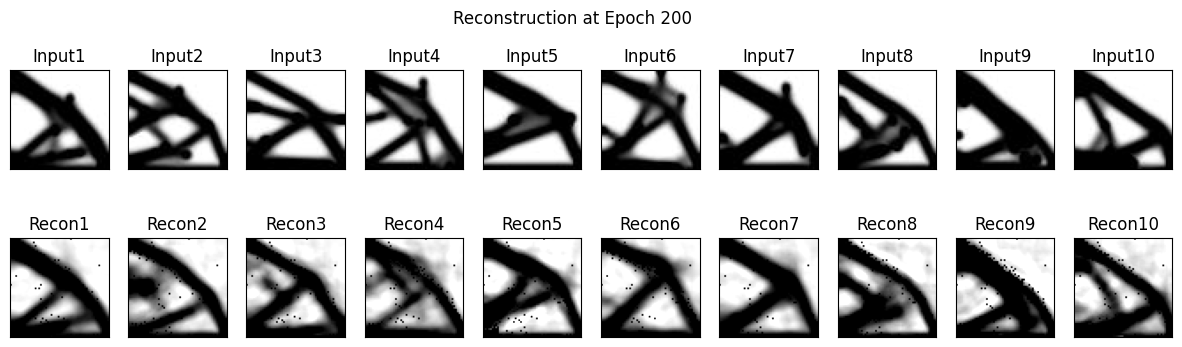

In [ ]:
# create DataLoader for training and validation data
train_dataset = TensorDataset(train_images, train_images)  # labels are not needed in autoencoder
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# set to loss function & optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)

# lists to track training and validation history
loss_train_history = []

# train the model
for epoch in range(num_epochs):
    autoencoder.train()
    total_loss = 0.0

    for x, _ in train_loader:
        optimizer.zero_grad()
        output = autoencoder(x)
        loss = criterion(output, x)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # calculate average metrics for the training set
    average_loss_train = total_loss / len(train_loader)

    # save training metrics
    loss_train_history.append(average_loss_train)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train_loss: {average_loss_train}")

    # perform inference every XX epochs
    if (epoch + 1) % 50 == 0 or epoch == 0:
        autoencoder.eval()
        recon_x_test = autoencoder(test_images)

        n = 10  # how many images to display
        plt.figure(figsize=(15, 4)) # figure size

        for i in range(n):
            # display original
            ax = plt.subplot(2, n, i + 1)
            plt.imshow(test_images.cpu()[i].reshape(56, 56), vmin=0, vmax=1, cmap="gray")
            plt.title(f"Input{i+1}")
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            # display reconstruction
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(recon_x_test.detach().cpu()[i].reshape(56, 56), vmin=0, vmax=1, cmap="gray")
            plt.title(f"Recon{i+1}")
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

        plt.suptitle(f"Reconstruction at Epoch {epoch+1}")
        plt.show()
        autoencoder.train()  # switch back to training mode

# save the model
torch.save(autoencoder.state_dict(), 'AE_model.pth')

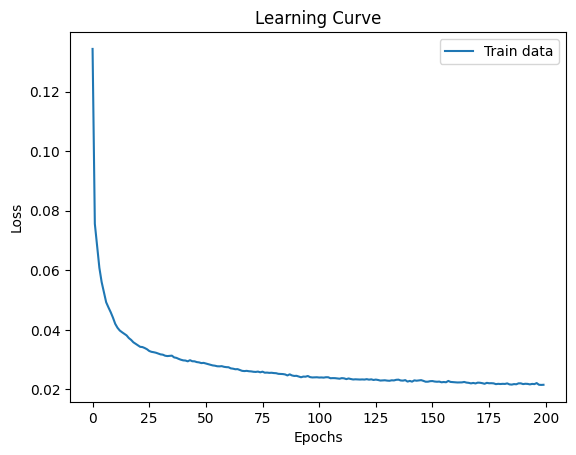

In [ ]:
# graph visualization
plot_loss(loss_train_history, 'Learning Curve')  # loss variation over epochs during training
plt.show()

## 9. Load & Evaluate model

- Compare the orginial image and the reconstructed image

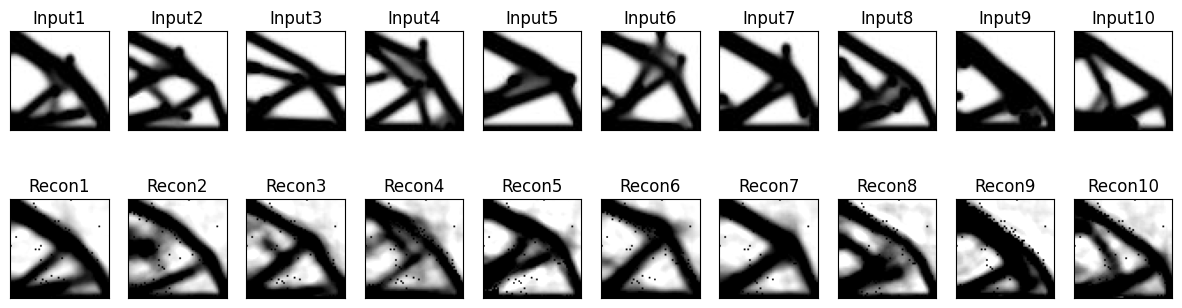

In [ ]:
autoencoder.eval().to(device)

# proceed reconstruction of the bracket images through the trained autoencoder model
recon_x_test = autoencoder(test_images)

n = 10  # how many images to display

plt.figure(figsize=(15, 4)) # figure size

for i in range(n):

    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images.cpu()[i].reshape(56,56), vmin=0, vmax=1, cmap="gray")  # reshape the images to show
    plt.title("Input"+str(i+1))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon_x_test.detach().cpu()[i].reshape(56, 56),vmin=0, vmax=1, cmap="gray")  # reshape the images to show
    plt.title("Recon"+str(i+1))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## 10. Anomaly detection test

오토인코더는 정상(normal) 데이터는 잘 복원하지만, 이상(anomaly) 데이터는 잘 못 복원함

    정상 데이터 → MSE 작음
    이상 데이터 → MSE 큼

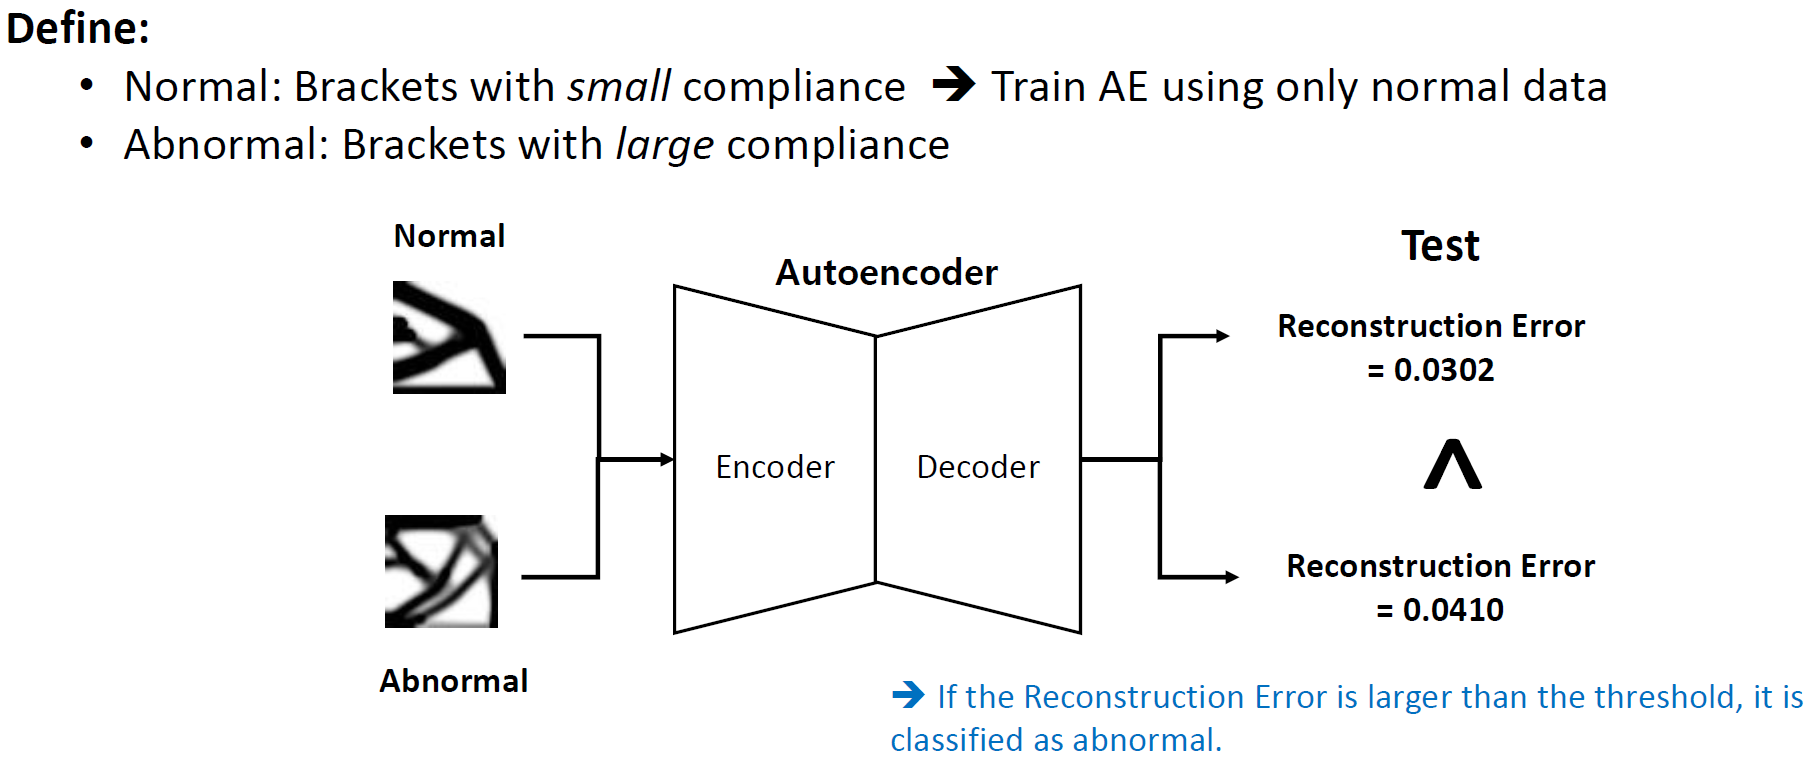

- Load abnormal dataset (data_1000.zip)

In [ ]:
!unzip dataset/data_1000.zip -d ./data1000

Archive:  dataset/data_1000.zip
 extracting: ./data1000/35.4527.jpg  
 extracting: ./data1000/35.4561.jpg  
 extracting: ./data1000/35.4579.jpg  
 extracting: ./data1000/35.4595.jpg  
 extracting: ./data1000/35.4617.jpg  
 extracting: ./data1000/35.4625.jpg  
 extracting: ./data1000/35.4637.jpg  
 extracting: ./data1000/35.4644.jpg  
 extracting: ./data1000/35.4668.jpg  
 extracting: ./data1000/35.4674.jpg  
 extracting: ./data1000/35.4681.jpg  
 extracting: ./data1000/35.4754.jpg  
 extracting: ./data1000/35.4787.jpg  
 extracting: ./data1000/35.4796.jpg  
 extracting: ./data1000/35.4853.jpg  
 extracting: ./data1000/35.4893.jpg  
 extracting: ./data1000/35.4994.jpg  
 extracting: ./data1000/35.5084.jpg  
 extracting: ./data1000/35.5102.jpg  
 extracting: ./data1000/35.5113.jpg  
 extracting: ./data1000/35.5141.jpg  
 extracting: ./data1000/35.5254.jpg  
 extracting: ./data1000/35.5281.jpg  
 extracting: ./data1000/35.5315.jpg  
 extracting: ./data1000/35.5316.jpg  
 extracting: ./dat

In [ ]:
# image size = 56 x 56, 1000 images

# specify the below path to the unzipped data (ensure it ends with '/')
# you can change the file path if needed
src_anom = './data1000/'

anom_files = os.listdir(src_anom)  # get the list of files in the source directory

ANom,ANom_Y = [],[]  # initialize empty lists for storing images and labels

# loop through the files, read each image, and normalize it (0 to 1)
for file in anom_files:
    ANom.append(img_read(src_anom, file) / 255.)
    ANom_Y.append(0)  # abnormal label: 0

ANom = np.array(ANom)
ANom_Y = np.array(ANom_Y)

# reshape the (image,image) images into (image*image,) size vectors
ANom = ANom.reshape((len(ANom), np.prod(ANom.shape[1:]))).astype('float32')

# randomly select 600 indices from 1000 samples / equals to number of test dataset(600)
random_indices = np.random.choice(len(ANom), 600, replace=False)

# select the 600 random samples
ANom = ANom[random_indices]
ANom_Y = ANom_Y[random_indices]

print("Datasets_anomaly_shape:{}".format(np.shape(ANom)))

Datasets_anomaly_shape:(600, 3136)


- Reconstruction of the test and anomaly data

In [ ]:
# convert data to PyTorch tensors
ANom_images = torch.tensor(ANom, dtype=torch.float32).to(device)

autoencoder.eval()

reconstructed_test = autoencoder(test_images)
reconstructed_anom = autoencoder(ANom_images)

- Compare the orginial image and the reconstructed image / abnormal dataset

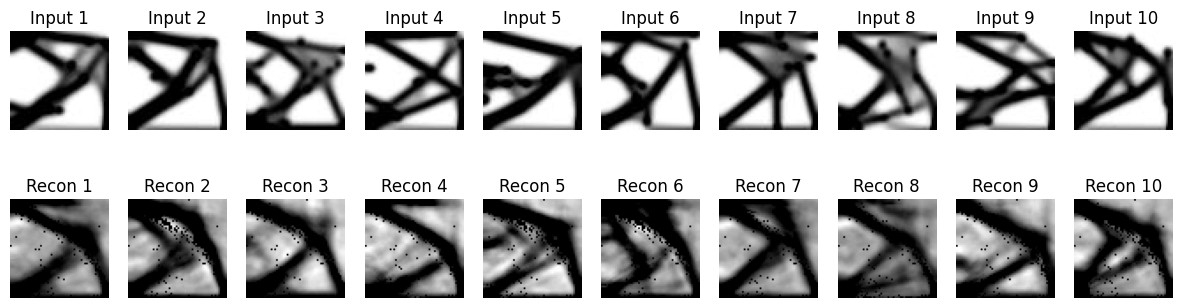

In [ ]:
# proceed reconstruction of the bracket images through the trained autoencoder model

n = 10  # how many images to display

plt.figure(figsize=(15, 4)) # figure size

for i in range(n):

    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(ANom_images.cpu()[i].reshape(56, 56), cmap='gray')  # reshape the images to show
    plt.title(f"Input {i+1}")
    ax.axis('off')

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_anom.detach().cpu()[i].reshape(56, 56), cmap='gray')  # reshape the images to show
    plt.title(f"Recon {i+1}")
    ax.axis('off')

plt.show()

- Visualize latent space using t-SNE (t-distributed Stochasstic Neighbor Embedding)

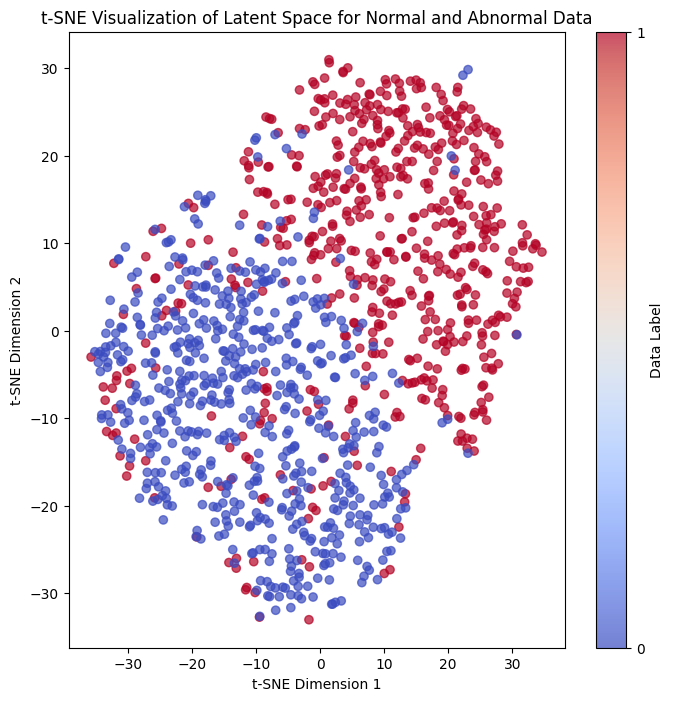

In [ ]:
# set the model to evaluation mode (no gradients will be computed)
autoencoder.eval()

with torch.no_grad():  # disable gradient computation for inference
    # get latent representations for normal and abnormal datasets
    z_test = autoencoder.encoder(test_images).cpu().detach().numpy()  # normal data
    z_anom = autoencoder.encoder(ANom_images).cpu().detach().numpy()  # abnormal data

# combine normal and abnormal latent vectors
z_combined = np.concatenate([z_test, z_anom])
labels_combined = np.concatenate([np.ones(len(z_test)), np.zeros(len(z_anom))])  # 1: Normal, 0: Abnormal

# apply t-SNE to reduce the latent space to 2 dimensions for visualization
tsne = TSNE(n_components=2, perplexity=40, random_state=0)
z_tsne = tsne.fit_transform(z_combined)

# create a scatter plot of the t-SNE results
plt.figure(figsize=(8, 8))
scatter = plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=labels_combined, cmap='coolwarm', alpha=0.7)
plt.colorbar(scatter, ticks=[0, 1], label='Data Label')
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization of Latent Space for Normal and Abnormal Data")
plt.show()

- Anomaly detection evaluation with metrics and confusion matrix

In [ ]:
# calculate MSE for normal and abnormal data
mse_test = torch.mean((test_images - reconstructed_test) ** 2, dim=1).detach().cpu().numpy()
mse_anom = torch.mean((ANom_images - reconstructed_anom) ** 2, dim=1).detach().cpu().numpy()

# set threshold for anomaly detection
threshold = 0.05  # adjust this threshold based on data

# classify based on MSE
y_pred_test = np.where(mse_test > threshold, 0, 1)  # 0 = abnormal, 1 = normal
y_pred_anom = np.where(mse_anom > threshold, 0, 1)

# combine test and anomaly predictions and true labels
y_pred = np.concatenate((y_pred_test, y_pred_anom))
y_true = np.concatenate((test_labels, ANom_Y))

In [ ]:
# confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
print(conf_mat)

TP = conf_mat[0][0]  # 실제 0(이상), 예측도 0 → 올바르게 이상 탐지
FN = conf_mat[0][1]  # 실제 0(이상), 예측은 1 → 이상인데 정상으로 잘못 분류
FP = conf_mat[1][0]  # 실제 1(정상), 예측은 0 → 정상인데 이상으로 잘못 분류
TN = conf_mat[1][1]  # 실제 1(정상), 예측도 1 → 올바르게 정상 탐지

accuracy = (TP + TN) / (TP + FN + FP + TN)
error_rate = (FP + FN) / (TP + FN + FP + TN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)

print(f"Accuracy: {accuracy:.2%}")  #정확도
print(f"Error Rate: {error_rate:.2%}")  #오류율
print(f"Precision: {precision:.2%}")  #정밀도
print(f"Recall: {recall:.2%}")  #재현율

[[596   4]
 [ 86 514]]
Accuracy: 92.50%
Error Rate: 7.50%
Precision: 87.39%
Recall: 99.33%


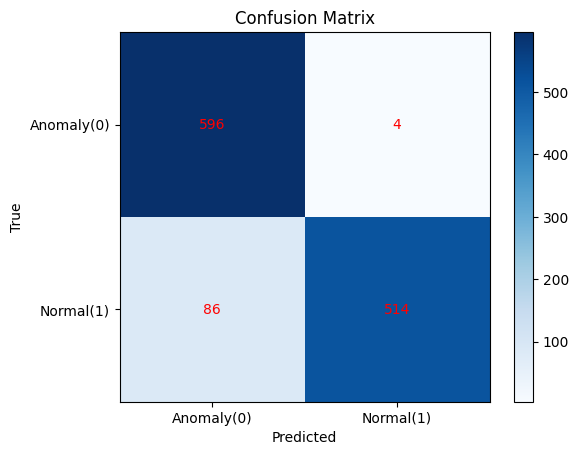

In [ ]:
# plot confusion matrix
plt.imshow(conf_mat, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['Anomaly(0)', 'Normal(1)'])
plt.yticks([0, 1], ['Anomaly(0)', 'Normal(1)'])
plt.xlabel('Predicted')
plt.ylabel('True')

for i in range(2):
    for j in range(2):
        plt.text(j, i, conf_mat[i, j], ha="center", va="center", color="red")
plt.show()